In [309]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve


import matplotlib.pyplot as plt
import seaborn as sns

In [247]:
pd.set_option('display.width', 250)

In [248]:
# file path
eeg_path = 'Dataset/EEG_data.csv'
demographic_path = 'Dataset/demographic_info.csv'

In [249]:
# load eeg data
eeg_df = pd.read_csv(eeg_path)
eeg_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [250]:
features = [
            'SubjectID', 'VideoID', 
            'Attention', 'Mediation', 
            'Raw', 'Delta', 'Theta', 'Alpha1', 
            'Alpha2', 'Beta1', 'Beta2', 'Gamma1',	
            'Gamma2', 'predefined', 'userdefined'
            ]

In [251]:
eeg_df.columns  = features

In [252]:
eeg_df.dtypes

SubjectID      float64
VideoID        float64
Attention      float64
Mediation      float64
Raw            float64
Delta          float64
Theta          float64
Alpha1         float64
Alpha2         float64
Beta1          float64
Beta2          float64
Gamma1         float64
Gamma2         float64
predefined     float64
userdefined    float64
dtype: object

In [253]:
eeg_df.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefined,userdefined
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


In [254]:
eeg_df['userdefined'].unique()

array([0., 1.])

In [255]:
# only numeric values
df = eeg_df.apply(pd.to_numeric)

In [256]:
demographic_df = pd.read_csv(demographic_path)
demographic_df.head()

,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M


In [257]:
demographic_df.dtypes

subject ID     int64
 age           int64
 ethnicity    object
 gender       object
dtype: object

In [258]:
demographic_df.describe()

,subject ID,age
count,10.00000,10.000000
mean,4.50000,25.400000
std,3.02765,2.319004
min,0.00000,24.000000
25%,2.25000,24.000000
50%,4.50000,24.500000
75%,6.75000,25.000000
max,9.00000,31.000000


In [259]:
# drop ethnicity
demographic_df.drop(columns={' ethnicity'}, inplace=True)

In [260]:
# changing the name
demographic_df.columns = ['SubjectID', 'Age', 'Gender']


In [261]:
# gender F = 0 | M = 1
demographic_df['Gender'] = demographic_df['Gender'].map({'F': 0, 'M': 1})

In [262]:
demographic_df.dtypes

SubjectID    int64
Age          int64
Gender       int64
dtype: object

In [263]:
# merge to dataframe
merged_df = pd.merge(eeg_df, demographic_df, on='SubjectID', how='inner')
merged_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefined,userdefined,Age,Gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,1
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,1
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,1
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,1
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,1


In [264]:
# calculate corelation
correlation_matrix = merged_df[features[2:]].corr()
print(correlation_matrix)

             Attention  Mediation       Raw     Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1    Gamma2  predefined  userdefined
Attention     1.000000   0.548606 -0.094933 -0.220403 -0.258356 -0.198662 -0.247011 -0.255361 -0.306624 -0.299903 -0.312734    0.001559    -0.119088
Mediation     0.548606   1.000000 -0.106923 -0.111810 -0.179887 -0.043275 -0.153740 -0.240774 -0.391365 -0.344922 -0.373253    0.015751    -0.023502
Raw          -0.094933  -0.106923  1.000000  0.048908  0.053443  0.045247  0.063867  0.090863  0.173631  0.186884  0.205772    0.010598    -0.001465
Delta        -0.220403  -0.111810  0.048908  1.000000  0.483386  0.426530  0.409898  0.395217  0.260820  0.210062  0.218673    0.012333     0.148588
Theta        -0.258356  -0.179887  0.053443  0.483386  1.000000  0.586956  0.553796  0.555541  0.368975  0.300468  0.308575    0.001602     0.147558
Alpha1       -0.198662  -0.043275  0.045247  0.426530  0.586956  1.000000  0.565232  0.549113  0.317923  0

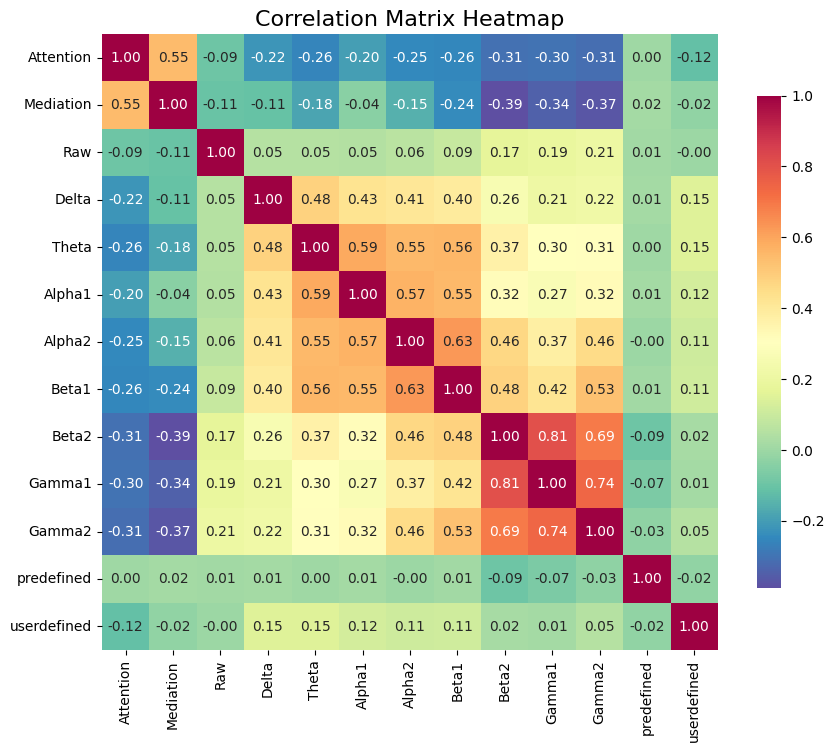

In [265]:
# visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,       
            fmt=".2f",          
            cmap='Spectral_r',   
            square=True,        
            cbar_kws={"shrink": 0.8})  
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [266]:
# Mask the diagonal and find the maximum correlation
mask = np.eye(correlation_matrix.shape[0], dtype=bool)
corr_values = correlation_matrix.where(~mask)

max_corr = corr_values.max().max()
print(f"Max correlation (excluding self-correlation): {max_corr}")


Max correlation (excluding self-correlation): 0.8089304500960287


In [ ]:
selected_features = [
    'Attention', 'Mediation', 
    'Delta', 'Theta', 'Alpha1', 
    'Alpha2', 'Beta1', 'Gamma1', 
    'predefined', 'userdefined'
]

In [371]:
# data preparation for lstm
X = merged_df[selected_features].values
y = merged_df['userdefined'].values

X = X.reshape((X.shape[0], 1, X.shape[1]))

In [372]:
# split the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [373]:
os.makedirs('saved_models', exist_ok=True)

In [374]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
results = []

for train_idx, val_idx in kfold.split(X, y):
    print(f"Training on fold {fold_no}...")

    # Split
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))  
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])  

    early_stopping = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

    # Train
    model.fit(X_train, y_train, epochs=150, batch_size=256, verbose=0)
    
    # Evaluate
    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold_no} - Loss: {loss}")
    results.append(loss)
    
    model.save(f'saved_models/lstm_fold_{fold_no}.h5')
    
    fold_no += 1

Training on fold 1...
Fold 1 - Loss: [0.6888440847396851, 0.5405616164207458]
Training on fold 2...


C:\Users\tasni\miniconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 2 - Loss: [0.690335750579834, 0.5316159129142761]
Training on fold 3...


KeyboardInterrupt: 

In [363]:
# training summary
print("\nCross-Validation Results:")
print(f"Mean Loss: {np.mean(results):.4f}")
print(f"Std Dev: {np.std(results):.4f}")



Cross-Validation Results:
Mean Loss: 0.5000
Std Dev: 0.5000


In [364]:
# find the best fold
losses = [r[0] for r in results] 
accuracies = [r[1] for r in results] 

# best model based on the loss
best_fold_idx = np.argmin(losses)
best_fold_no = best_fold_idx + 1
print(f"\nBest fold based on Loss: Fold {best_fold_no} with Loss {losses[best_fold_idx]:.4f}")

# best model based on accuracy
best_fold_idx_acc = np.argmax(accuracies)
best_fold_no_acc = best_fold_idx_acc + 1

print(f"Best fold based on Accuracy: Fold {best_fold_no_acc} with Accuracy {accuracies[best_fold_idx_acc]:.4f}")


Best fold based on Loss: Fold 10 with Loss 0.0000
Best fold based on Accuracy: Fold 1 with Accuracy 1.0000


In [365]:
# best model
best_model = load_model(f'saved_models/lstm_fold_{best_fold_no}.h5')

In [366]:
# test the model
test_loss = best_model.evaluate(X_test, y_test)
test_loss

81/81 [==============================] - 1s 1ms/step - loss: 2.1088e-06 - accuracy: 1.0000


[2.1088430912641343e-06, 1.0]

In [367]:
# predict test cases
y_pred_prob = best_model.predict(X_test).flatten()
y_pred_prob

81/81 [==============================] - 1s 1ms/step


array([9.9999875e-01, 2.4382032e-06, 9.9999845e-01, ..., 1.8856334e-06,
       2.0006564e-06, 9.9999827e-01], dtype=float32)

In [368]:
y_pred_class = (y_pred_prob > 0.5).astype(int)
print(np.unique(y_pred_class))

[0 1]


In [369]:
X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[2]))
result_df = pd.DataFrame(X_test_2d, columns=selected_features[:-2]) 
result_df['True_Label'] = y_test
result_df['Predicted_Prob'] = y_pred_prob
result_df['Predicted_Label'] = y_pred_class

result_df.to_csv('test_results.csv', index=False)

ValueError: Shape of passed values is (2563, 9), indices imply (2563, 7)

In [370]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000


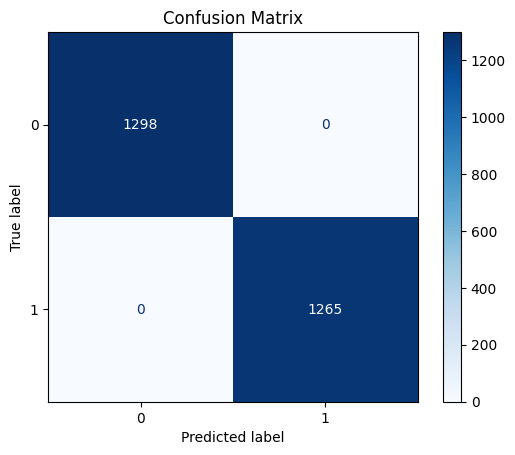

In [359]:
# confusion metric
cm = confusion_matrix(y_test, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


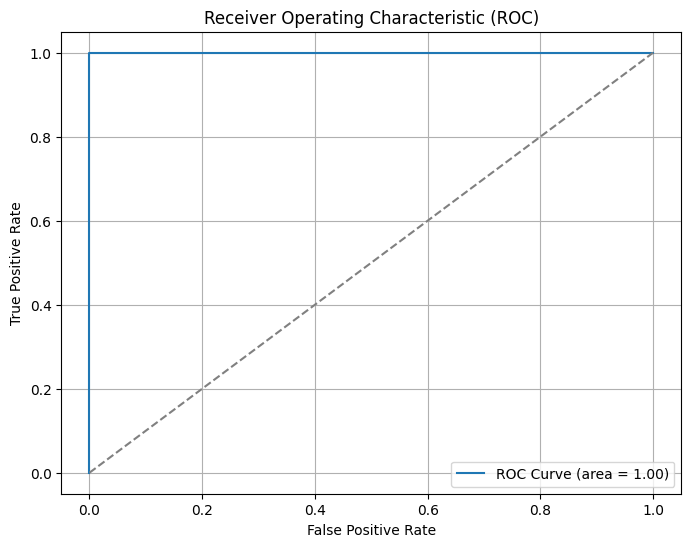

In [360]:
# Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

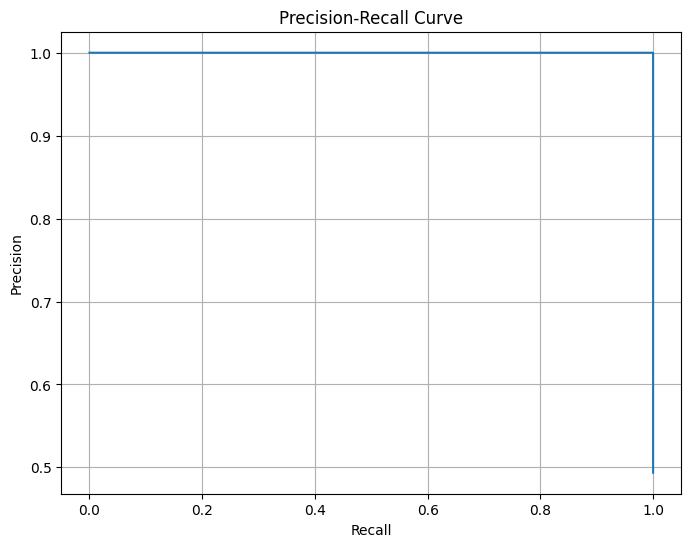

In [361]:
# precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()